In [1]:
pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.dates as mdates

from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
weather_data= pd.read_csv("weather.csv")

In [4]:
weather_data.head(10)

,date,maxtp(Maximum Air Temperature - degrees C),mintp(Minimum Air Temperature - degrees C),gmin(Grass Minimum Temperature - degrees C),rain(Precipitation Amount - mm),cbl (Mean CBL Pressure-hpa),wdsp(Mean Wind Speed - knot),pe(Potential Evapotranspiration - mm),evap(Evaporation -mm)
0,1-Jan-42,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4
1,2-Jan-42,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9
2,3-Jan-42,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6
3,4-Jan-42,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7
4,5-Jan-42,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7
5,6-Jan-42,5.1,0.7,-3.7,0.0,1021.1,9.7,0.4,0.5
6,7-Jan-42,7.1,0.5,-1,0.0,1021.7,10.3,0.2,0.2
7,8-Jan-42,7.1,1.4,0.2,0.0,1016.8,9.3,0.2,0.2
8,9-Jan-42,4.5,0.7,0.9,0.2,1012.0,11.8,0.5,0.7
9,10-Jan-42,5.3,-2.8,-4.1,0.0,1015.9,4.0,0.0,0.1


In [5]:
weather_data.shape

(29889, 9)

In [6]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29889 entries, 0 to 29888
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   date                                         29889 non-null  object 
 1   maxtp(Maximum Air Temperature - degrees C)   29889 non-null  float64
 2   mintp(Minimum Air Temperature - degrees C)   29889 non-null  float64
 3   gmin(Grass Minimum Temperature - degrees C)  29889 non-null  object 
 4   rain(Precipitation Amount - mm)              29889 non-null  float64
 5   cbl (Mean CBL Pressure-hpa)                  29889 non-null  float64
 6   wdsp(Mean Wind Speed - knot)                 29889 non-null  float64
 7   pe(Potential Evapotranspiration - mm)        29889 non-null  float64
 8   evap(Evaporation -mm)                        29889 non-null  object 
dtypes: float64(6), object(3)
memory usage: 2.1+ MB


In [7]:
weather_data.isnull().sum()

date                                           0
maxtp(Maximum Air Temperature - degrees C)     0
mintp(Minimum Air Temperature - degrees C)     0
gmin(Grass Minimum Temperature - degrees C)    0
rain(Precipitation Amount - mm)                0
cbl (Mean CBL Pressure-hpa)                    0
wdsp(Mean Wind Speed - knot)                   0
pe(Potential Evapotranspiration - mm)          0
evap(Evaporation -mm)                          0
dtype: int64

In [8]:
# function for processing the dataframe in order to parse the dates , adjusting the year from 1942 to 2023
def parse_dates(date):
    try:
        return pd.to_datetime(date, format='%d-%b-%y')
    except ValueError:
        return pd.NaT

# Applying the date parsing function to the 'date' column 
weather_data['date'] = weather_data['date'].apply(parse_dates)
weather_data.dropna(subset=['date'], inplace=True)

# Adjust the year for dates that are incorrectly parsed as 21st century
weather_data['date'] = weather_data['date'].apply(lambda d: d.replace(year=d.year - 100) if d.year > 2023 else d)

# Extract the year from the 'date' column
weather_data['year'] = weather_data['date'].dt.year

print(weather_data.head())

# Checking for unique years 
unique_years = weather_data['year'].unique()
unique_years.sort()
print('Unique years in the dataset after adjustment:', unique_years)

        date  maxtp(Maximum Air Temperature - degrees C)  \
0 1942-01-01                                         9.7   
1 1942-01-02                                         9.9   
2 1942-01-03                                        11.2   
3 1942-01-04                                         9.2   
4 1942-01-05                                         3.5   

   mintp(Minimum Air Temperature - degrees C)  \
0                                         6.8   
1                                         7.9   
2                                         8.9   
3                                         2.7   
4                                        -0.8   

  gmin(Grass Minimum Temperature - degrees C)  \
0                                         4.7   
1                                         6.7   
2                                         7.2   
3                                         3.4   
4                                           0   

   rain(Precipitation Amount - mm)  cbl (Mean CBL

In [9]:
#renaming the column name for better understanding
weather_data.rename(columns={
    'maxtp(Maximum Air Temperature - degrees C)': 'maxtp',
    'mintp(Minimum Air Temperature - degrees C)': 'mintp',
    'gmin(Grass Minimum Temperature - degrees C)': 'gmin',
    'rain(Precipitation Amount - mm)': 'rain',
    'cbl (Mean CBL Pressure-hpa)': 'cbl',
    'wdsp(Mean Wind Speed - knot)': 'wdsp',
    'pe(Potential Evapotranspiration - mm)': 'pe',
    'evap(Evaporation -mm)': 'evap',
    'year': 'year'
}, inplace=True)

In [10]:
weather_data

,date,maxtp,mintp,gmin,rain,cbl,wdsp,pe,evap,year
0,1942-01-01,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4,1942
1,1942-01-02,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9,1942
2,1942-01-03,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6,1942
3,1942-01-04,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7,1942
4,1942-01-05,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7,1942
...,...,...,...,...,...,...,...,...,...,...
29884,2023-10-27,13.2,4.1,-1,2.9,974.2,5.8,0.5,0.8,2023
29885,2023-10-28,14.1,9.3,7.2,4.4,970.1,8.5,0.7,1,2023
29886,2023-10-29,12.4,2.5,-1.2,11.1,972.0,5.2,0.4,0.6,2023
29887,2023-10-30,12.7,1.7,-1.3,2.1,979.9,4.1,0.3,0.5,2023


In [11]:
weather_data['year'].unique()

array([1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023])

In [12]:
print(weather_data['year'].min())

1942


In [13]:
print(weather_data['year'].max())

2023


In [14]:
weather_data.dtypes

date     datetime64[ns]
maxtp           float64
mintp           float64
gmin             object
rain            float64
cbl             float64
wdsp            float64
pe              float64
evap             object
year              int32
dtype: object

C:\Users\nikhi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


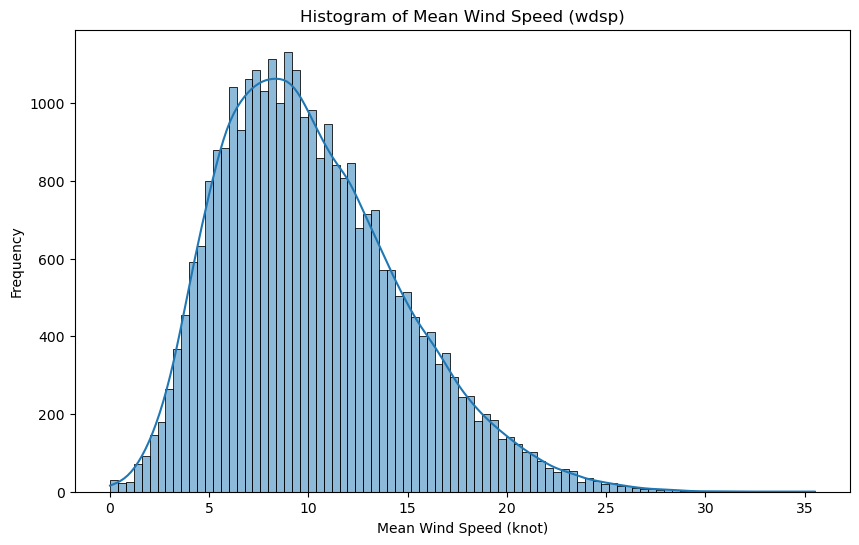

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(weather_data['wdsp'].dropna(), kde=True)
plt.title('Histogram of Mean Wind Speed (wdsp)')
plt.xlabel('Mean Wind Speed (knot)')
plt.ylabel('Frequency')
plt.show()

#### Preliminary assessment and component of the raw time series

In [16]:
weather_data_df = weather_data.copy()

In [17]:
# Create a range of years from 2019 to 2023
year_range = range(2019, 2023)

# Set 'year' as the index and filter only the rows within the specified range
weather_data_df.set_index('year', inplace=True)
weather_data_df = weather_data_df.loc[year_range]

# Resetting the index if needed
weather_data_df.reset_index(inplace=True)

# Display the updated DataFrame
print(weather_data_df)


      year       date  maxtp  mintp  gmin  rain     cbl  wdsp   pe evap
0     2019 2019-01-01    9.2    1.8   6.9   0.2  1027.8   7.5  0.3  0.4
1     2019 2019-01-02    7.6    1.6    -1   0.0  1032.6   4.2  0.5  0.6
2     2019 2019-01-03    7.9    4.9  -1.6   0.0  1031.1   4.0  0.5  0.6
3     2019 2019-01-04    6.5    4.6   4.2   0.0  1030.9   4.8  0.7  0.9
4     2019 2019-01-05    8.4    2.0  -1.9   0.0  1027.7   5.2  0.4  0.5
...    ...        ...    ...    ...   ...   ...     ...   ...  ...  ...
1456  2022 2022-12-27   11.1    2.0   0.1   1.0  1001.0   9.5  0.5  0.6
1457  2022 2022-12-28   11.3    5.0     2   5.2   983.5   9.8  0.5  0.6
1458  2022 2022-12-29    9.6    4.7   3.2   0.8   982.6  12.2  0.7  0.8
1459  2022 2022-12-30   11.4    6.9   3.1   2.5   975.3  12.8  0.8  0.9
1460  2022 2022-12-31   10.0    5.3   4.4   2.6   982.7   3.7  0.3  0.4

[1461 rows x 10 columns]


In [18]:
weather_data_df

,year,date,maxtp,mintp,gmin,rain,cbl,wdsp,pe,evap
0,2019,2019-01-01,9.2,1.8,6.9,0.2,1027.8,7.5,0.3,0.4
1,2019,2019-01-02,7.6,1.6,-1,0.0,1032.6,4.2,0.5,0.6
2,2019,2019-01-03,7.9,4.9,-1.6,0.0,1031.1,4.0,0.5,0.6
3,2019,2019-01-04,6.5,4.6,4.2,0.0,1030.9,4.8,0.7,0.9
4,2019,2019-01-05,8.4,2.0,-1.9,0.0,1027.7,5.2,0.4,0.5
...,...,...,...,...,...,...,...,...,...,...
1456,2022,2022-12-27,11.1,2.0,0.1,1.0,1001.0,9.5,0.5,0.6
1457,2022,2022-12-28,11.3,5.0,2,5.2,983.5,9.8,0.5,0.6
1458,2022,2022-12-29,9.6,4.7,3.2,0.8,982.6,12.2,0.7,0.8
1459,2022,2022-12-30,11.4,6.9,3.1,2.5,975.3,12.8,0.8,0.9


In [19]:
weather_data_df.shape

(1461, 10)

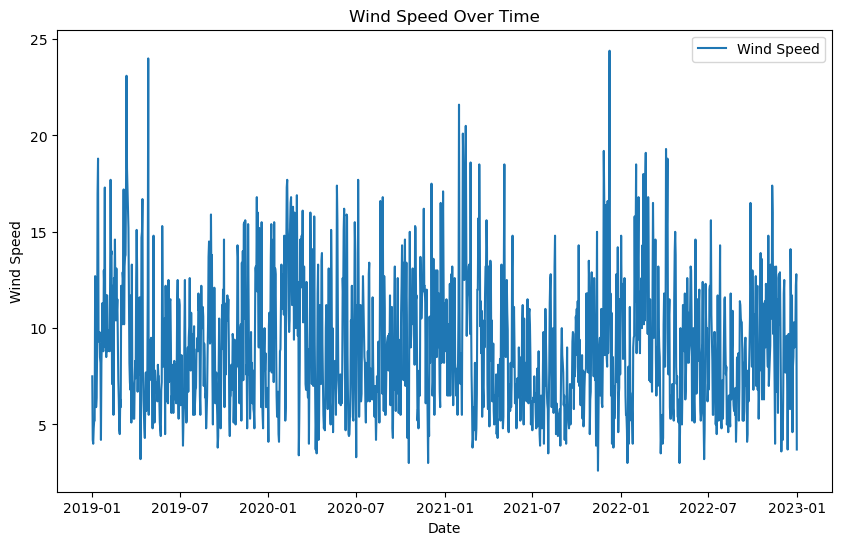

In [20]:
import matplotlib.pyplot as plt

# Assuming 'weather_data_df' is your DataFrame
plt.figure(figsize=(10, 6))
plt.plot(weather_data_df['date'], weather_data_df['wdsp'], label='Wind Speed')
plt.title('Wind Speed Over Time')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()


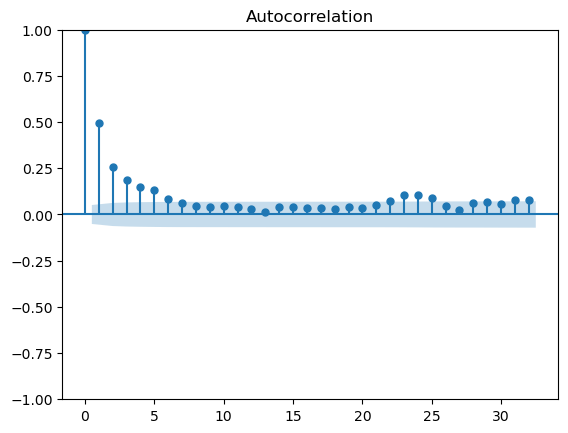

In [21]:
smt.graphics.plot_acf(weather_data_df['wdsp']);

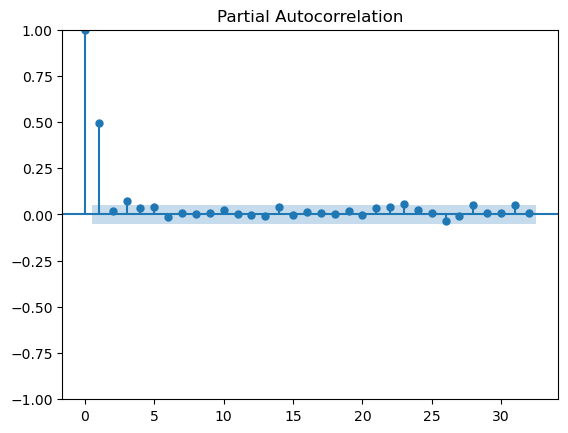

In [22]:
smt.graphics.plot_pacf(weather_data_df['wdsp']);

In [23]:
weather_decompose = weather_data_df.copy()

In [24]:
weather_decompose.set_index('date', inplace=True)

In [25]:
#### Decomposing the mean wind speed into 3 components
decompose = seasonal_decompose(weather_decompose['wdsp'])

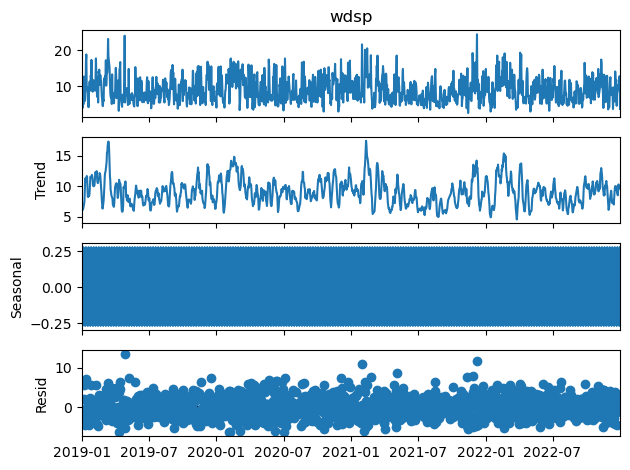

In [26]:
decompose.plot();

In [27]:
# Performing seasonal decomposition using an additive model
result_add = seasonal_decompose(weather_decompose['wdsp'].dropna(), model='additive', period=365)

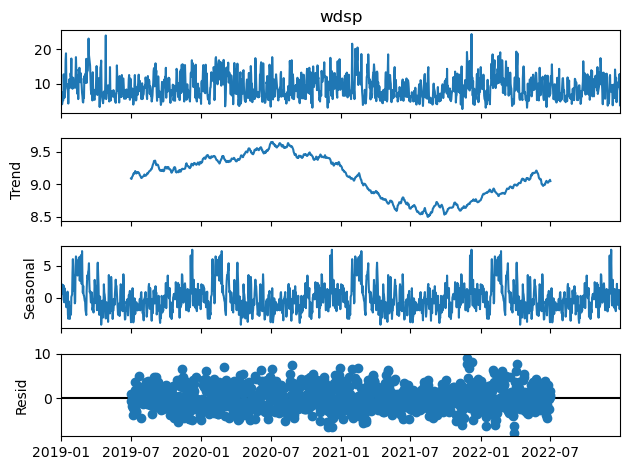

In [28]:
result_add.plot();

### Model 1: Simple Time Series Model

In [29]:
weather_model1 = weather_data.copy()

In [30]:
weather_model1

,date,maxtp,mintp,gmin,rain,cbl,wdsp,pe,evap,year
0,1942-01-01,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4,1942
1,1942-01-02,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9,1942
2,1942-01-03,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6,1942
3,1942-01-04,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7,1942
4,1942-01-05,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7,1942
...,...,...,...,...,...,...,...,...,...,...
29884,2023-10-27,13.2,4.1,-1,2.9,974.2,5.8,0.5,0.8,2023
29885,2023-10-28,14.1,9.3,7.2,4.4,970.1,8.5,0.7,1,2023
29886,2023-10-29,12.4,2.5,-1.2,11.1,972.0,5.2,0.4,0.6,2023
29887,2023-10-30,12.7,1.7,-1.3,2.1,979.9,4.1,0.3,0.5,2023


In [31]:
# Creating a range of years from 2019 to 2023
year_range = range(2019, 2023)

# Setting 'year' as the index 
weather_model1.set_index('year', inplace=True)
# setting the index range from the year 2019 to 2023
weather_model1 = weather_model1.loc[year_range]

# Resetting the index
weather_model1.reset_index(inplace=True)

# Displaying the modified DataFrame
print(weather_model1)

      year       date  maxtp  mintp  gmin  rain     cbl  wdsp   pe evap
0     2019 2019-01-01    9.2    1.8   6.9   0.2  1027.8   7.5  0.3  0.4
1     2019 2019-01-02    7.6    1.6    -1   0.0  1032.6   4.2  0.5  0.6
2     2019 2019-01-03    7.9    4.9  -1.6   0.0  1031.1   4.0  0.5  0.6
3     2019 2019-01-04    6.5    4.6   4.2   0.0  1030.9   4.8  0.7  0.9
4     2019 2019-01-05    8.4    2.0  -1.9   0.0  1027.7   5.2  0.4  0.5
...    ...        ...    ...    ...   ...   ...     ...   ...  ...  ...
1456  2022 2022-12-27   11.1    2.0   0.1   1.0  1001.0   9.5  0.5  0.6
1457  2022 2022-12-28   11.3    5.0     2   5.2   983.5   9.8  0.5  0.6
1458  2022 2022-12-29    9.6    4.7   3.2   0.8   982.6  12.2  0.7  0.8
1459  2022 2022-12-30   11.4    6.9   3.1   2.5   975.3  12.8  0.8  0.9
1460  2022 2022-12-31   10.0    5.3   4.4   2.6   982.7   3.7  0.3  0.4

[1461 rows x 10 columns]


#### A. Simple Moving Average

In [32]:
# Calculating the simple moving average for 'wdsp' with a window size of 365 days
weather_model1['SMA'] = weather_model1['wdsp'].rolling(window=365, min_periods=1).mean()
weather_model1['SMA_6months'] = weather_model1['wdsp'].rolling(window=182, min_periods=1).mean()

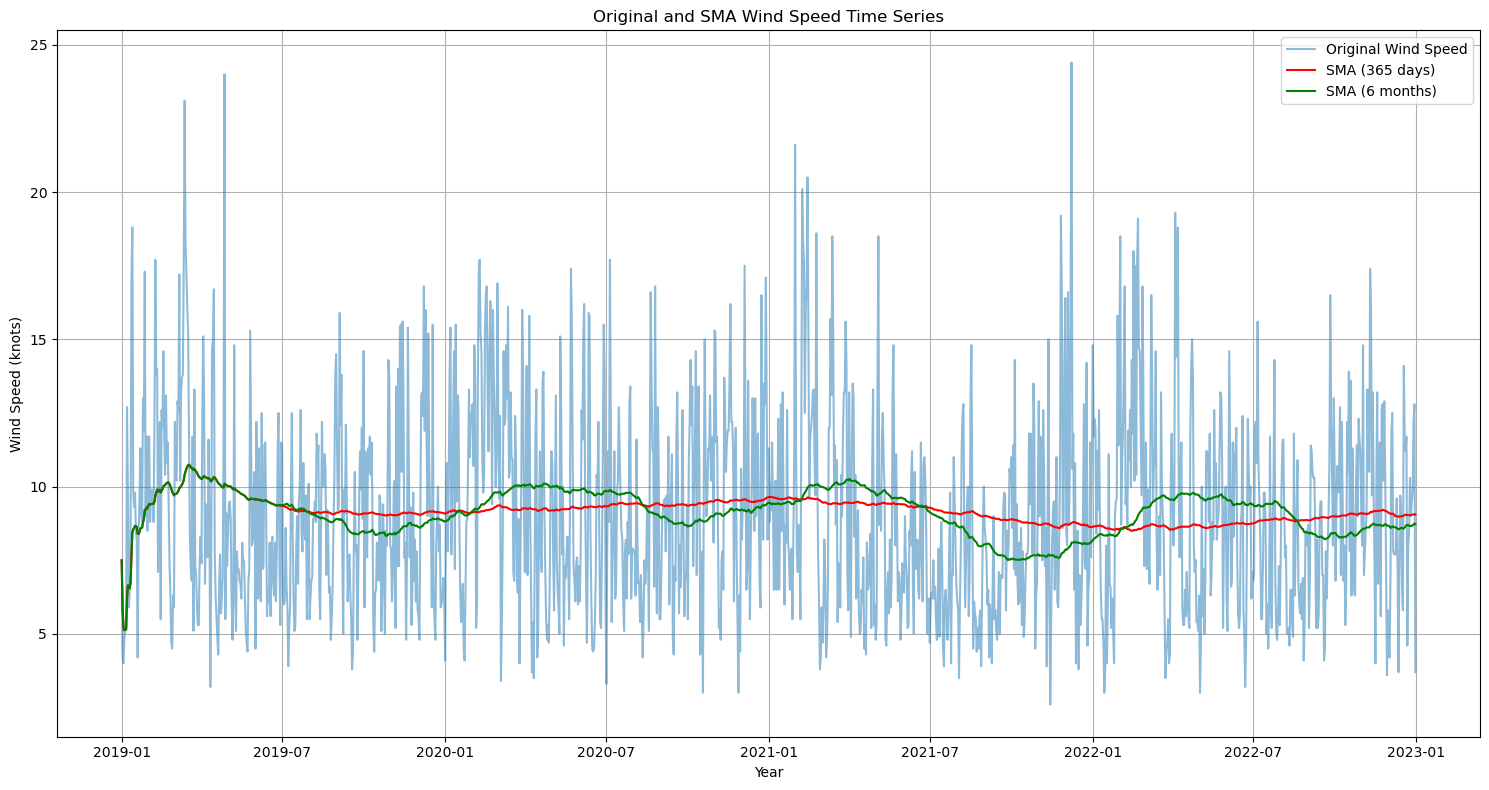

In [33]:
# Plotting the original and SMA time series
plt.figure(figsize=(15, 8))
plt.plot(weather_model1['date'], weather_model1['wdsp'], label='Original Wind Speed', alpha=0.5)
plt.plot(weather_model1['date'], weather_model1['SMA'], label='SMA (365 days)', color='red')
plt.plot(weather_model1['date'], weather_model1['SMA_6months'], label='SMA (6 months)', color='green')
plt.title('Original and SMA Wind Speed Time Series')
plt.xlabel('Year')
plt.ylabel('Wind Speed (knots)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
weather_model1.set_index('year', inplace=True)

sma_mean_absolute_error = mean_absolute_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["SMA"]
)
sma_root_mean_squared_error = mean_squared_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["SMA"]
)**0.5
sma_mean_absolute_perc_error = mean_absolute_percentage_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["SMA"]
) 

print(" SMA- MAE:{:.3f}, RMSE : {:.3f}, MAPE : {:.3f}".format(sma_mean_absolute_error, sma_root_mean_squared_error
                                                             , sma_mean_absolute_perc_error))

 SMA- MAE:2.748, RMSE : 3.392, MAPE : 0.352


#### B. Weighted Moving Average (WMA)

In [35]:
weather_model1['WMA'] = weather_model1['wdsp'].rolling(window=365, min_periods=1).apply(lambda x: np.average(x, weights=np.arange(1, len(x) + 1)))

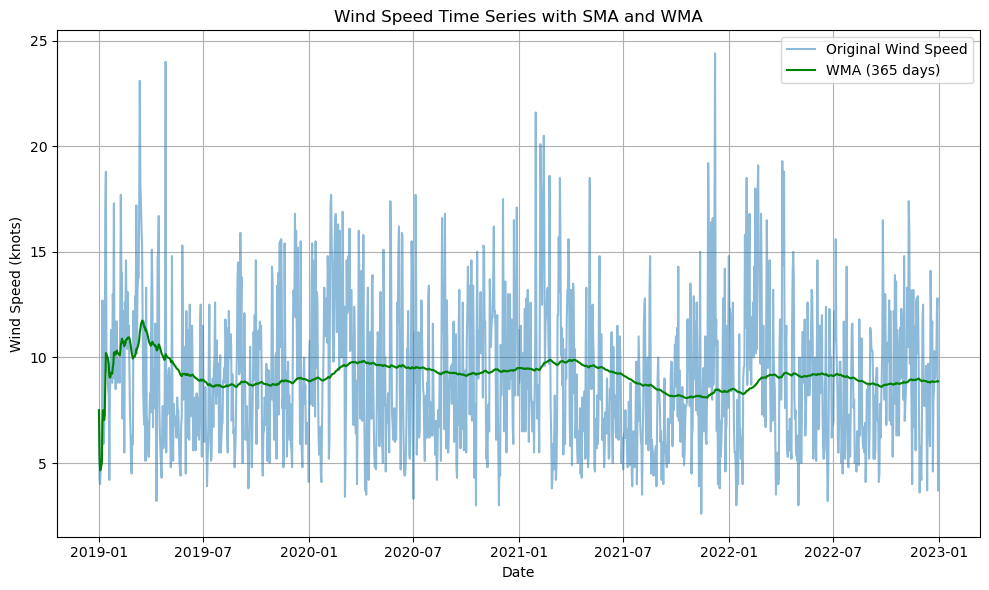

In [36]:
# Plotting the original, SMA, and WMA time series
plt.figure(figsize=(10, 6))
plt.plot(weather_model1['date'], weather_model1['wdsp'], label='Original Wind Speed', alpha=0.5)
plt.plot(weather_model1['date'], weather_model1['WMA'], label='WMA (365 days)', color='green')
plt.title('Wind Speed Time Series with SMA and WMA')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
weather_model1 = weather_model1.loc[2019:].dropna(subset=["wdsp", "WMA"])

wma_mean_absolute_error = mean_absolute_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["WMA"]
)
wma_root_mean_squared_error = mean_squared_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["WMA"]
)**0.5
wma_mean_absolute_perc_error = mean_absolute_percentage_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["WMA"]
) 

print(" WMA- MAE:{:.3f}, RMSE : {:.3f}, MAPE : {:.3f}".format(wma_mean_absolute_error, wma_root_mean_squared_error
                                                             , wma_mean_absolute_perc_error))

 WMA- MAE:2.721, RMSE : 3.364, MAPE : 0.348


#### C. Exponential Weighted Moving Average

In [38]:
# Calculating the weighted moving average for 'wdsp'. We will use the exponentially weighted moving average (EWMA) as a form of WMA.
weather_model1['Exp_WMA'] = weather_model1['wdsp'].ewm(span=365, adjust=False).mean()


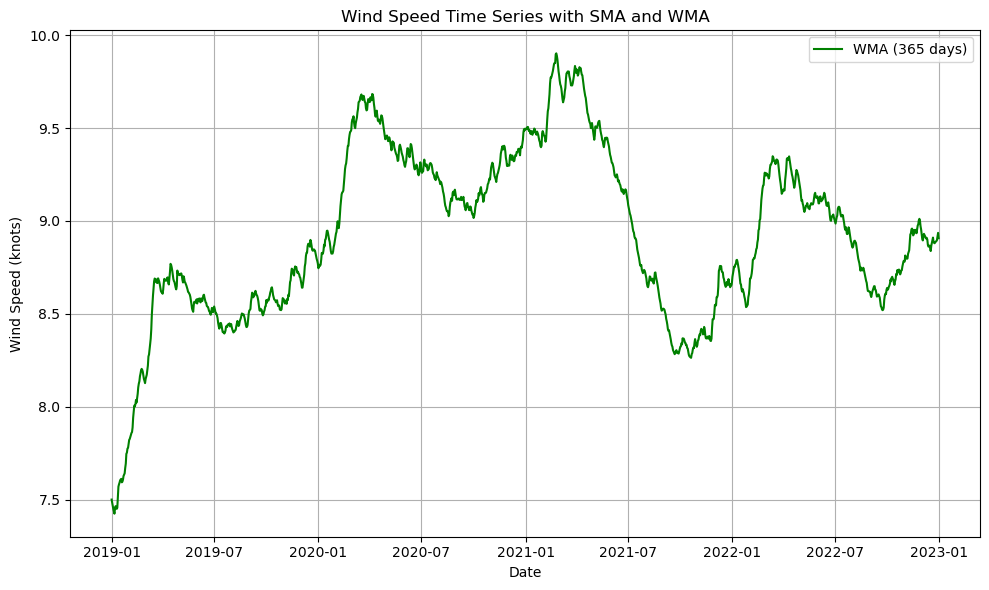

In [39]:
# Plotting the original, SMA, and WMA time series
plt.figure(figsize=(10, 6))

plt.plot(weather_model1['date'], weather_model1['Exp_WMA'], label='WMA (365 days)', color='green')
plt.title('Wind Speed Time Series with SMA and WMA')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

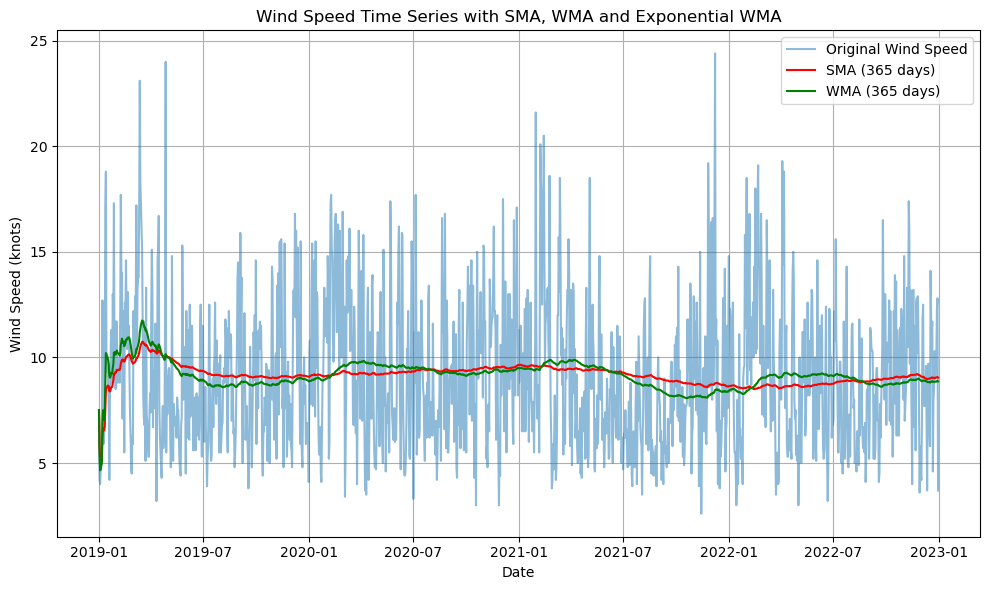

In [40]:
weather_model1['WMA'] = weather_model1['wdsp'].rolling(window=365, min_periods=1).apply(lambda x: np.average(x, weights=np.arange(1, len(x) + 1)))


# Plotting the original, SMA, and WMA time series
plt.figure(figsize=(10, 6))
plt.plot(weather_model1['date'], weather_model1['wdsp'], label='Original Wind Speed', alpha=0.5)
#plt.plot(weather_model1['date'], weather_model1['SMA_6months'], label='SMA (6 months)', color='purple')
plt.plot(weather_model1['date'], weather_model1['SMA'], label='SMA (365 days)', color='red')
plt.plot(weather_model1['date'], weather_model1['WMA'], label='WMA (365 days)', color='green')
#plt.plot(weather_model1['date'], weather_model1['Exp_WMA'], label=' Exponential WMA (365 days)', color='yellow')
plt.title('Wind Speed Time Series with SMA, WMA and Exponential WMA')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
weather_model1 = weather_model1.loc[2019:].dropna(subset=["wdsp", "WMA"])

Ewma_mean_absolute_error = mean_absolute_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["Exp_WMA"]
)
Ewma_root_mean_squared_error = mean_squared_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["Exp_WMA"]
)**0.5
Ewma_mean_absolute_perc_error = mean_absolute_percentage_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["Exp_WMA"]
) 

print(" Exponential WMA- MAE:{:.3f}, RMSE : {:.3f}, MAPE : {:.3f}".format(Ewma_mean_absolute_error, Ewma_root_mean_squared_error
                                                             , Ewma_mean_absolute_perc_error))

 Exponential WMA- MAE:2.733, RMSE : 3.402, MAPE : 0.342


#### Evaluation of Model 1

In [42]:
sma_mean_absolute_error = mean_absolute_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["SMA"]
)
sma_root_mean_squared_error = mean_squared_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["SMA"]
)**0.5
sma_mean_absolute_perc_error = mean_absolute_percentage_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["SMA"]
) 

print(" SMA- MAE:{:.3f}, RMSE : {:.3f}, MAPE : {:.3f}".format(sma_mean_absolute_error, sma_root_mean_squared_error
                                                             , sma_mean_absolute_perc_error))

 SMA- MAE:2.748, RMSE : 3.392, MAPE : 0.352


In [43]:
weather_model1 = weather_model1.loc[2019:].dropna(subset=["wdsp", "WMA"])

wma_mean_absolute_error = mean_absolute_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["WMA"]
)
wma_root_mean_squared_error = mean_squared_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["WMA"]
)**0.5
wma_mean_absolute_perc_error = mean_absolute_percentage_error(
    weather_model1.loc[2019:]["wdsp"],
    weather_model1.loc[2019:]["WMA"]
) 

print(" WMA- MAE:{:.3f}, RMSE : {:.3f}, MAPE : {:.3f}".format(wma_mean_absolute_error, wma_root_mean_squared_error
                                                             , wma_mean_absolute_perc_error))

 WMA- MAE:2.721, RMSE : 3.364, MAPE : 0.348


### Model 2: Simple Exponential Smoothening

In [44]:
weather_model2 = weather_data_df.copy()

In [45]:
weather_model2

,year,date,maxtp,mintp,gmin,rain,cbl,wdsp,pe,evap
0,2019,2019-01-01,9.2,1.8,6.9,0.2,1027.8,7.5,0.3,0.4
1,2019,2019-01-02,7.6,1.6,-1,0.0,1032.6,4.2,0.5,0.6
2,2019,2019-01-03,7.9,4.9,-1.6,0.0,1031.1,4.0,0.5,0.6
3,2019,2019-01-04,6.5,4.6,4.2,0.0,1030.9,4.8,0.7,0.9
4,2019,2019-01-05,8.4,2.0,-1.9,0.0,1027.7,5.2,0.4,0.5
...,...,...,...,...,...,...,...,...,...,...
1456,2022,2022-12-27,11.1,2.0,0.1,1.0,1001.0,9.5,0.5,0.6
1457,2022,2022-12-28,11.3,5.0,2,5.2,983.5,9.8,0.5,0.6
1458,2022,2022-12-29,9.6,4.7,3.2,0.8,982.6,12.2,0.7,0.8
1459,2022,2022-12-30,11.4,6.9,3.1,2.5,975.3,12.8,0.8,0.9


In [46]:
weather_data_df.set_index('date', inplace=True)

In [47]:
weather_data_df.sort_index(inplace=True)

In [48]:
# Filtering the data to include only 2019 to 2022
start_date = '2019-01-01'
end_date = '2022-12-31'
weather_model2 = weather_data_df[start_date:end_date]

In [49]:
# Applying Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(weather_model2['wdsp'], initialization_method='legacy-heuristic').fit()

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [50]:
print(ses_model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                   wdsp   No. Observations:                 1461
Model:             SimpleExpSmoothing   SSE                          14550.374
Optimized:                       True   AIC                           3362.102
Trend:                           None   BIC                           3372.676
Seasonal:                        None   AICC                          3362.129
Seasonal Periods:                None   Date:                 Tue, 02 Jan 2024
Box-Cox:                        False   Time:                         23:44:30
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3913006                alpha                 True
initial_level              7.5000000                

In [51]:
# Forecasting using the fitted SES model for the year 2023
forecast_2023 = ses_model.forecast(365)

In [52]:
# Reseting index to use 'date' in plotting
weather_model2.reset_index(inplace=True)
forecast_2023_df = pd.DataFrame({'date': pd.date_range(start='2023-01-01', periods=365, freq='D'), 'forecast': forecast_2023})

Having produced the forecast, we can plot the original series, the smoothed series along with the forecast.

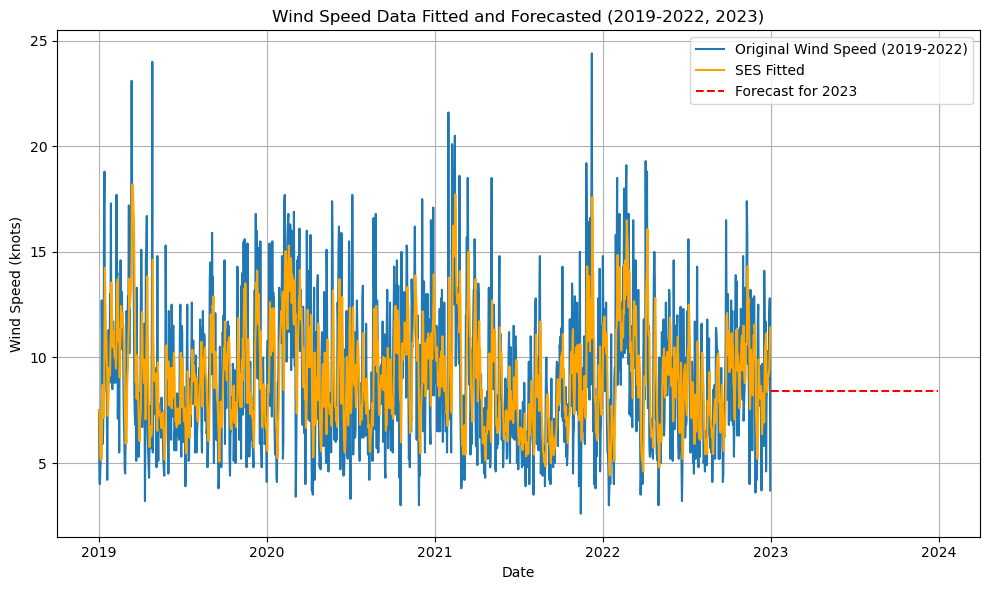

In [53]:
# Ploting the original, SES forecast, and extended forecast time series
plt.figure(figsize=(10, 6))
plt.plot(weather_model2['date'], weather_model2['wdsp'], label='Original Wind Speed (2019-2022)')
plt.plot(weather_model2['date'], ses_model.fittedvalues, label='SES Fitted', color='orange')
plt.plot(forecast_2023_df['date'], forecast_2023_df['forecast'], label='Forecast for 2023', color='red', linestyle='--')
plt.title('Wind Speed Data Fitted and Forecasted (2019-2022, 2023)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The forecast is flat.This is because the simple exponential smoothing model is not capable of capturing the trend in the data.

Evaluating the model by calculating the MAE, RMSE and MAPE for the fitted model.

#### Evaluation of Model 2

In [54]:
# Evaluation of the  single exponential smoothing
ses_mean_absolute_error = mean_absolute_error(
    weather_model2["wdsp"],
    ses_model.fittedvalues
)
ses_root_mean_squared_error = mean_squared_error(
    weather_model2["wdsp"],
    ses_model.fittedvalues)**0.5
ses_mean_absolute_perc_error = mean_absolute_percentage_error(
    weather_model2["wdsp"],
    ses_model.fittedvalues
) 

print(" SES- MAE:{:.3f}, RMSE : {:.3f}, MAPE : {:.3f}".format(ses_mean_absolute_error, ses_root_mean_squared_error
                                                             , ses_mean_absolute_perc_error))

 SES- MAE:2.477, RMSE : 3.156, MAPE : 0.304


### Model 3: Holt Linear's trend (Double Exponential Smoothing)

Double Exponential smoothing is also known as Holt's Linear Trend model, using the column 'mean wind speed (wdsp)' 

In [55]:
weather_model3 = weather_data_df.copy()

In [56]:
weather_model3

,year,maxtp,mintp,gmin,rain,cbl,wdsp,pe,evap
date,,,,,,,,,
2019-01-01,2019,9.2,1.8,6.9,0.2,1027.8,7.5,0.3,0.4
2019-01-02,2019,7.6,1.6,-1,0.0,1032.6,4.2,0.5,0.6
2019-01-03,2019,7.9,4.9,-1.6,0.0,1031.1,4.0,0.5,0.6
2019-01-04,2019,6.5,4.6,4.2,0.0,1030.9,4.8,0.7,0.9
2019-01-05,2019,8.4,2.0,-1.9,0.0,1027.7,5.2,0.4,0.5
...,...,...,...,...,...,...,...,...,...
2022-12-27,2022,11.1,2.0,0.1,1.0,1001.0,9.5,0.5,0.6
2022-12-28,2022,11.3,5.0,2,5.2,983.5,9.8,0.5,0.6
2022-12-29,2022,9.6,4.7,3.2,0.8,982.6,12.2,0.7,0.8


In [57]:
weather_data_df.sort_index(inplace=True)

In [58]:
# Filtering the data to include only 2019 to 2022
start_date = '2019-01-01'
end_date = '2022-12-31'
weather_model3 = weather_data_df[start_date:end_date]

In [59]:
# Apply Holt's Linear Trend method

fit_holt_model = Holt(weather_model3["wdsp"]).fit()

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [60]:
print(fit_holt_model.summary())

                              Holt Model Results                              
Dep. Variable:                   wdsp   No. Observations:                 1461
Model:                           Holt   SSE                          15750.683
Optimized:                       True   AIC                           3481.911
Trend:                       Additive   BIC                           3503.059
Seasonal:                        None   AICC                          3481.969
Seasonal Periods:                None   Date:                 Tue, 02 Jan 2024
Box-Cox:                        False   Time:                         23:44:30
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5402752                alpha                 True
smoothing_trend            0.0377368                

In [61]:
# Forecasting for the year 2023
forecast_2023_holt = fit_holt_model.forecast(365)
print(forecast_2023_holt)

2023-01-01     7.513447
2023-01-02     7.453176
2023-01-03     7.392905
2023-01-04     7.332635
2023-01-05     7.272364
                ...    
2023-12-27   -14.184096
2023-12-28   -14.244367
2023-12-29   -14.304638
2023-12-30   -14.364909
2023-12-31   -14.425180
Freq: D, Length: 365, dtype: float64


In [62]:
# Reseting index to use 'date' in plotting
weather_model3.reset_index(inplace=True)
forecast_2023_holt_df = pd.DataFrame({'date': pd.date_range(start='2023-01-01', periods=365, freq='D'), 'forecast': forecast_2023_holt})

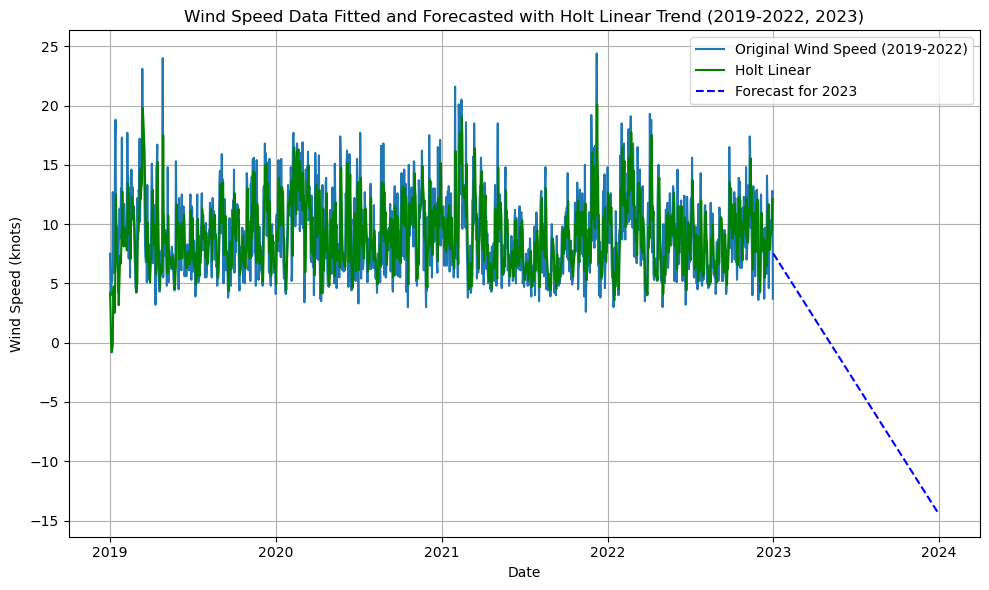

In [63]:
# Ploting the fitted model and the forecast
plt.figure(figsize=(10, 6))
plt.plot(weather_model3['date'], weather_model3['wdsp'], label='Original Wind Speed (2019-2022)')
plt.plot(weather_model3['date'], fit_holt_model.fittedvalues, label='Holt Linear', color='green')
plt.plot(forecast_2023_holt_df['date'], forecast_2023_holt_df['forecast'], label='Forecast for 2023', color='blue', linestyle='--')
plt.title('Wind Speed Data Fitted and Forecasted with Holt Linear Trend (2019-2022, 2023)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Evaluation of Model 3

In [64]:
holt_mean_absolute_error = mean_absolute_error(
    weather_model3["wdsp"],
    fit_holt_model.fittedvalues
)
holt_root_mean_squared_error = mean_squared_error(
    weather_model3["wdsp"],
    fit_holt_model.fittedvalues
)
holt_mean_absolute_perecentage_error = mean_absolute_percentage_error(
    weather_model3["wdsp"],
    fit_holt_model.fittedvalues
)

print(" SES- MAE:{:.3f}, RMSE : {:.3f}, MAPE : {:.3f}".format(holt_mean_absolute_error, holt_root_mean_squared_error
                                                             , holt_mean_absolute_perecentage_error))

 SES- MAE:2.550, RMSE : 10.781, MAPE : 0.308


### Model 4: Triple Exponential Smoothing

In [65]:
weather_model4 = weather_data.copy()

In [66]:
weather_model4

,date,maxtp,mintp,gmin,rain,cbl,wdsp,pe,evap,year
0,1942-01-01,9.7,6.8,4.7,0.0,1020.3,17.2,1.1,1.4,1942
1,1942-01-02,9.9,7.9,6.7,0.1,1016.2,15.2,0.7,0.9,1942
2,1942-01-03,11.2,8.9,7.2,1.5,1006.8,14.0,0.5,0.6,1942
3,1942-01-04,9.2,2.7,3.4,3.5,1001.5,17.0,0.6,0.7,1942
4,1942-01-05,3.5,-0.8,0,0.6,1013.4,13.0,0.6,0.7,1942
...,...,...,...,...,...,...,...,...,...,...
29884,2023-10-27,13.2,4.1,-1,2.9,974.2,5.8,0.5,0.8,2023
29885,2023-10-28,14.1,9.3,7.2,4.4,970.1,8.5,0.7,1,2023
29886,2023-10-29,12.4,2.5,-1.2,11.1,972.0,5.2,0.4,0.6,2023
29887,2023-10-30,12.7,1.7,-1.3,2.1,979.9,4.1,0.3,0.5,2023


In [67]:
year_range = range(2019, 2024)

# Setting 'year' as the index and filter only the rows within the specified range
weather_model4.set_index("year", inplace=True)
weather_model4 = weather_model4.loc[year_range]

# Resetting the index if needed
weather_model4.reset_index(inplace=True)


In [68]:
weather_model4['date'] = pd.to_datetime(weather_model4['date'], format='%Y-%m-%d')
weather_model4.set_index('date', inplace=True)

In [69]:
# splitting the dataset into train (from year 2019 to 2022) and test as year 2023 in order to forecast 
train = weather_model4['wdsp'].loc["2019-01-01":"2022-12-31"]
print(train)
test = weather_model4['wdsp'].loc["2023-01-01":"2023-10-31"]
print(test)

date
2019-01-01     7.5
2019-01-02     4.2
2019-01-03     4.0
2019-01-04     4.8
2019-01-05     5.2
              ... 
2022-12-27     9.5
2022-12-28     9.8
2022-12-29    12.2
2022-12-30    12.8
2022-12-31     3.7
Name: wdsp, Length: 1461, dtype: float64
date
2023-01-01     5.5
2023-01-02     6.2
2023-01-03    12.5
2023-01-04    13.7
2023-01-05    10.3
              ... 
2023-10-27     5.8
2023-10-28     8.5
2023-10-29     5.2
2023-10-30     4.1
2023-10-31     6.8
Name: wdsp, Length: 304, dtype: float64


In [70]:
train

date
2019-01-01     7.5
2019-01-02     4.2
2019-01-03     4.0
2019-01-04     4.8
2019-01-05     5.2
              ... 
2022-12-27     9.5
2022-12-28     9.8
2022-12-29    12.2
2022-12-30    12.8
2022-12-31     3.7
Name: wdsp, Length: 1461, dtype: float64

In [71]:
test

date
2023-01-01     5.5
2023-01-02     6.2
2023-01-03    12.5
2023-01-04    13.7
2023-01-05    10.3
              ... 
2023-10-27     5.8
2023-10-28     8.5
2023-10-29     5.2
2023-10-30     4.1
2023-10-31     6.8
Name: wdsp, Length: 304, dtype: float64

In [72]:
# Applying the triple exponential smoothing
fit_test = ExponentialSmoothing(train,
                                           trend='add',
                                           seasonal='add',
                                           seasonal_periods=365, 
                                           initialization_method='estimated').fit()
print(fit_test.summary());

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                     wdsp   No. Observations:                 1461
Model:             ExponentialSmoothing   SSE                          10880.590
Optimized:                         True   AIC                           3671.482
Trend:                         Additive   BIC                           5622.340
Seasonal:                      Additive   AICC                          3924.948
Seasonal Periods:                   365   Date:                 Tue, 02 Jan 2024
Box-Cox:                          False   Time:                         23:44:32
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.2934835                alpha                 True
smoothing_trend       

In [73]:
#predicting the mean wind speed for the year 2023
prediction_test = fit_test.forecast(len(test))
prediction_test

2023-01-01    10.028776
2023-01-02     9.698092
2023-01-03     9.066747
2023-01-04    10.185147
2023-01-05     9.728549
                ...    
2023-10-27    10.898303
2023-10-28    11.372440
2023-10-29    11.546580
2023-10-30     9.220418
2023-10-31    11.269107
Freq: D, Length: 304, dtype: float64

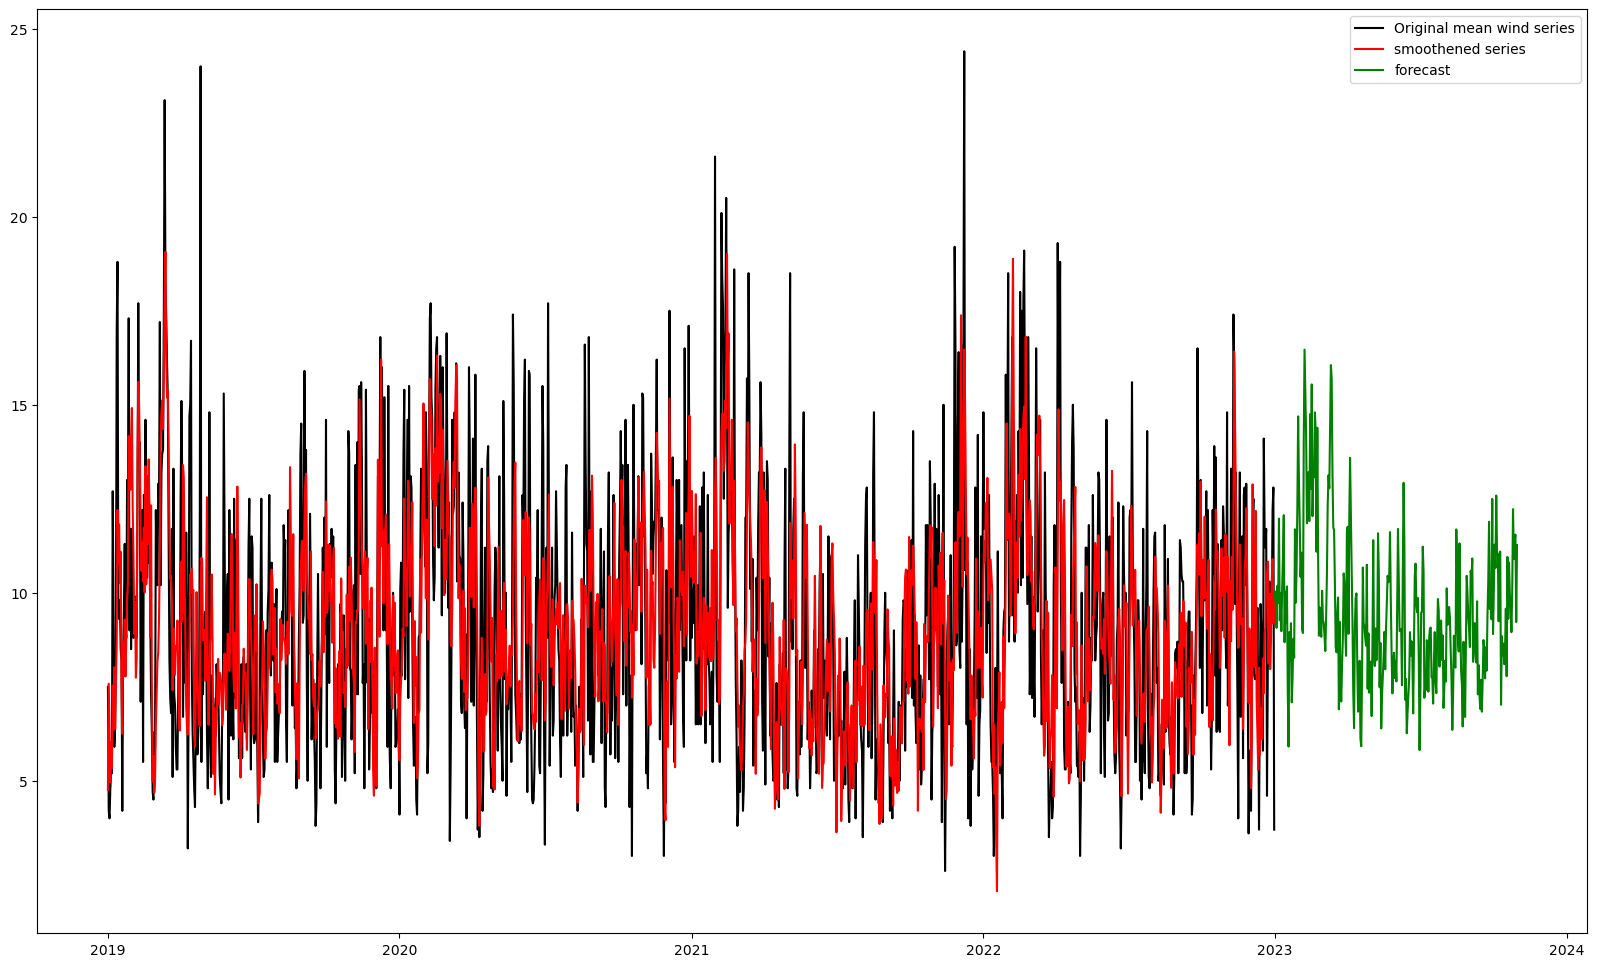

In [74]:
plt.figure(figsize=(20,12))
plt.plot(train, color = "black", label = "Original mean wind series")
plt.plot(fit_test.fittedvalues, color = "red", label = "smoothened series")
plt.plot(prediction_test, color="green", label = "forecast")
plt.legend()

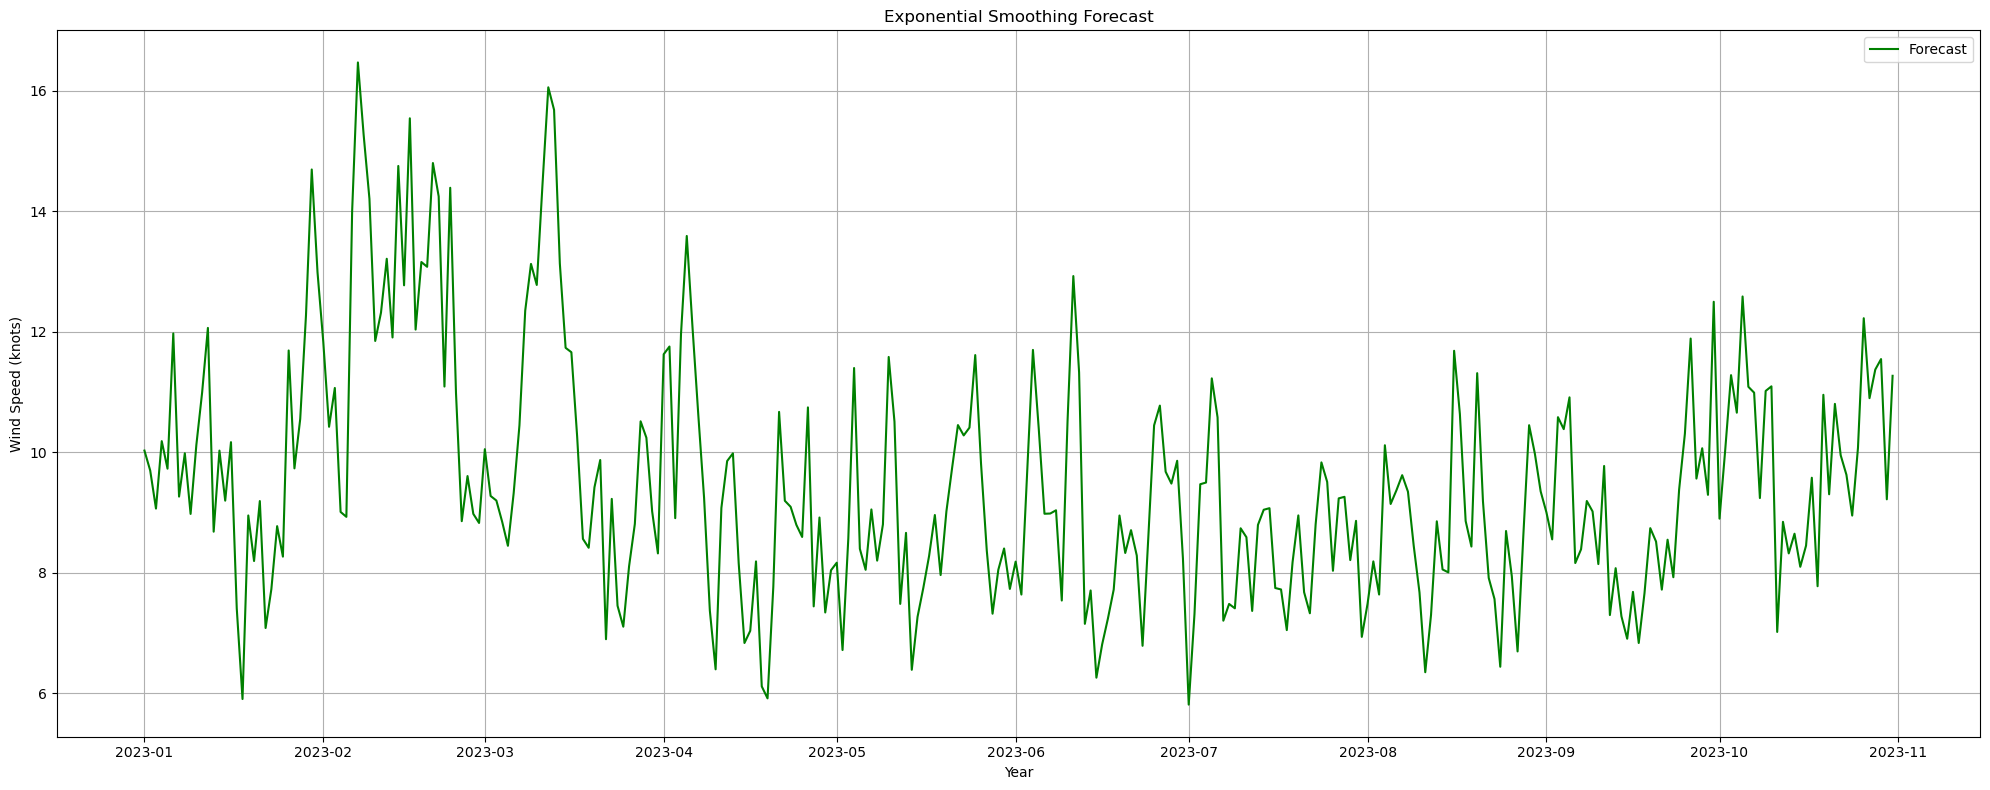

In [75]:
plt.figure(figsize=(20, 8))
plt.plot(prediction_test, color="green", label="Forecast")
plt.legend()
plt.title("Exponential Smoothing Forecast")
plt.xlabel("Year")
plt.ylabel("Wind Speed (knots)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Evaluation of Model 4

In [76]:
tes_mean_absolute_error = mean_absolute_error(
    train,
    fit_test.fittedvalues
)

tes_mean_squared_error = mean_squared_error(
    train,
    fit_test.fittedvalues
)**0.5
tes_mean_absolute_perc_error = mean_absolute_percentage_error(
    train,
    fit_test.fittedvalues
)

print("SES- MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.3f}".format(tes_mean_absolute_error, tes_mean_squared_error, tes_mean_absolute_perc_error))


SES- MAE: 2.154, RMSE: 2.729, MAPE: 0.266


In [77]:
test_mean_absolute_error = mean_absolute_error(
    test,
    prediction_test
)

test_mean_squared_error = mean_squared_error(
    test,
    prediction_test
)**0.5
test_mean_absolute_perc_error = mean_absolute_percentage_error(
    test,
    prediction_test
)

print("SES- MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.3f}".format(test_mean_absolute_error, test_mean_squared_error, test_mean_absolute_perc_error))


SES- MAE: 2.849, RMSE: 3.507, MAPE: 0.391


### Model 5 - ARIMA (Autoregressive Integrated Moving Average Models)

In [78]:
weather_model5 = weather_data.copy()

In [79]:
year_range = range(2019, 2024)

# Setting 'year' as the index and filter only the rows within the specified range
weather_model5.set_index("year", inplace=True)
weather_model5 = weather_model5.loc[year_range]
weather_model5.reset_index(inplace=True)

In [80]:
weather_model5.index.freq = "MS"

In [81]:
weather_model5['date'] = pd.to_datetime(weather_model5['date'], format='%Y-%m-%d')
weather_model5.set_index('date', inplace=True)

In [82]:
train = weather_model5.loc["2019-01-01":"2022-12-31"]
print(train)
test = weather_model5.loc["2023-01-01":"2023-10-31"]
print(test)

            year  maxtp  mintp  gmin  rain     cbl  wdsp   pe evap
date                                                              
2019-01-01  2019    9.2    1.8   6.9   0.2  1027.8   7.5  0.3  0.4
2019-01-02  2019    7.6    1.6    -1   0.0  1032.6   4.2  0.5  0.6
2019-01-03  2019    7.9    4.9  -1.6   0.0  1031.1   4.0  0.5  0.6
2019-01-04  2019    6.5    4.6   4.2   0.0  1030.9   4.8  0.7  0.9
2019-01-05  2019    8.4    2.0  -1.9   0.0  1027.7   5.2  0.4  0.5
...          ...    ...    ...   ...   ...     ...   ...  ...  ...
2022-12-27  2022   11.1    2.0   0.1   1.0  1001.0   9.5  0.5  0.6
2022-12-28  2022   11.3    5.0     2   5.2   983.5   9.8  0.5  0.6
2022-12-29  2022    9.6    4.7   3.2   0.8   982.6  12.2  0.7  0.8
2022-12-30  2022   11.4    6.9   3.1   2.5   975.3  12.8  0.8  0.9
2022-12-31  2022   10.0    5.3   4.4   2.6   982.7   3.7  0.3  0.4

[1461 rows x 9 columns]
            year  maxtp  mintp  gmin  rain     cbl  wdsp   pe evap
date                                 

<Axes: xlabel='date'>

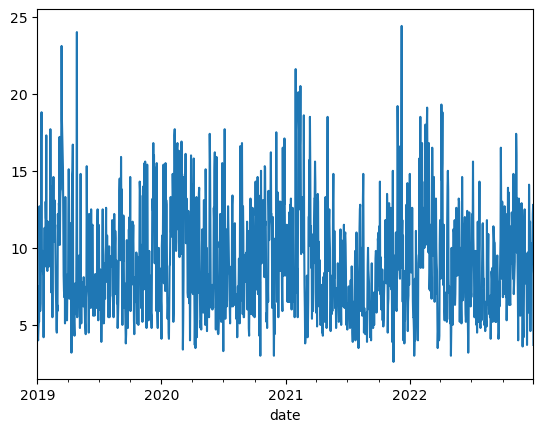

In [83]:
train["wdsp"].plot()

Augmented Dickey-Fuller test To ckeck stationary data

In [84]:
def test_stationary(timeseries):
    
    print("--------------------------------------")
    print("Results of Dickey-Fuller test:")
    dftest = adfuller(train['wdsp'], autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test statistic', 'p-value', 'Lags used', 'Number of observations'])
    for key,value in dftest[4].items():
        dfoutput['Confidence Interval (%s)'%key]=value
    print(dfoutput)

In [85]:
test_stationary(train['wdsp'])

--------------------------------------
Results of Dickey-Fuller test:
Test statistic              -1.575764e+01
p-value                      1.202256e-28
Lags used                    2.000000e+00
Number of observations       1.458000e+03
Confidence Interval (1%)    -3.434843e+00
Confidence Interval (5%)    -2.863524e+00
Confidence Interval (10%)   -2.567826e+00
dtype: float64


As p-value is very small, it means it is the stationary data

As the data is the stationary data, there is no need to calculate the Differences.

In [86]:
#FirstDifference = (train["wdsp"] - train["wdsp"].shift(1)).dropna()

In [87]:
#FirstDifference.plot()

In [88]:
#round(adfuller(FirstDifference)[1],3)

Now we can produce autocorrelation and  partial autocorrelation function plots to try to determine the orders of p and q, the autoregressive and moving average

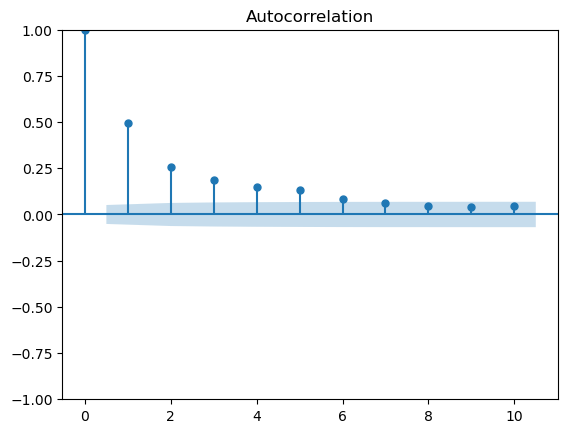

In [89]:
plot_acf(train["wdsp"], lags =10);

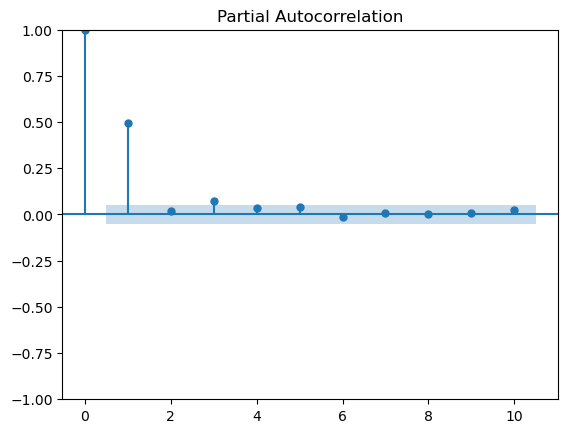

In [90]:
plot_pacf(train["wdsp"], lags =10);

The ACF plot shows a gradual decline, while the PACF plot cuts off after the first lag, suggesting an AR(1) model might be suitable. However, to confirm the most suitable model, will also fit close variations of this model, such as (1,0,0)(1,0,1)(1,0,2)(1,1,0)(1,1,1)(1,1,2)(2,1,0)(2,1,1)(1,2,1)(2,2,1)(0,1,1)(1,0,5)

#### ARIMA(1,0,0)

In [91]:
model100 = ARIMA(train["wdsp"], order = (1,0,0))
fit100 = model100.fit()
print(fit100.summary())

                               SARIMAX Results                                
Dep. Variable:                   wdsp   No. Observations:                 1461
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3657.165
Date:                Tue, 02 Jan 2024   AIC                           7320.331
Time:                        23:44:34   BIC                           7336.191
Sample:                    01-01-2019   HQIC                          7326.247
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0954      0.174     52.193      0.000       8.754       9.437
ar.L1          0.4941      0.021     23.231      0.000       0.452       0.536
sigma2         8.7435      0.305     28.642      0.0

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### ARIMA (1,0,1)

In [92]:
model101 = ARIMA(train["wdsp"], order = (1,0,1))
fit101 = model101.fit()
print(fit101.summary())

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   wdsp   No. Observations:                 1461
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3656.885
Date:                Tue, 02 Jan 2024   AIC                           7321.770
Time:                        23:44:34   BIC                           7342.918
Sample:                    01-01-2019   HQIC                          7329.659
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0952      0.179     50.922      0.000       8.745       9.445
ar.L1          0.5299      0.044     11.919      0.000       0.443       0.617
ma.L1         -0.0477      0.050     -0.947      0.3

#### ARIMA (1,0,2)

In [93]:
model102 = ARIMA(train["wdsp"], order = (1,0,2))
fit102 = model102.fit()
print(fit102.summary())

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   wdsp   No. Observations:                 1461
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3651.598
Date:                Tue, 02 Jan 2024   AIC                           7313.196
Time:                        23:44:34   BIC                           7339.630
Sample:                    01-01-2019   HQIC                          7323.056
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0926      0.206     44.071      0.000       8.688       9.497
ar.L1          0.7639      0.054     14.042      0.000       0.657       0.871
ma.L1         -0.2843      0.059     -4.791      0.0

#### ARIMA(1,1,1)

In [94]:
model111 = ARIMA(train["wdsp"], order = (1,1,1))
fit111 = model111.fit()
print(fit111.summary())

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   wdsp   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3655.039
Date:                Tue, 02 Jan 2024   AIC                           7316.078
Time:                        23:44:35   BIC                           7331.937
Sample:                    01-01-2019   HQIC                          7321.994
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4604      0.022     21.043      0.000       0.418       0.503
ma.L1         -0.9779      0.006   -170.096      0.000      -0.989      -0.967
sigma2         8.7367      0.281     31.138      0.0

#### ARIMA (1,0,5)

In [95]:
model105 = ARIMA(train["wdsp"], order = (1,0,5))
fit105 = model105.fit()
print(fit105.summary())

C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   wdsp   No. Observations:                 1461
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -3650.919
Date:                Tue, 02 Jan 2024   AIC                           7317.839
Time:                        23:44:35   BIC                           7360.134
Sample:                    01-01-2019   HQIC                          7333.616
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0931      0.202     44.918      0.000       8.696       9.490
ar.L1          0.6871      0.132      5.196      0.000       0.428       0.946
ma.L1         -0.2051      0.132     -1.552      0.1

#### conclusion

The ARIMA (1,0,2) has the lowest AIC. Using auto_arima() we can automatically determine the model order.

In [96]:
auto_arima(train["wdsp"])

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True)

### Diagnostic

#### ARIMA(1,0,2)

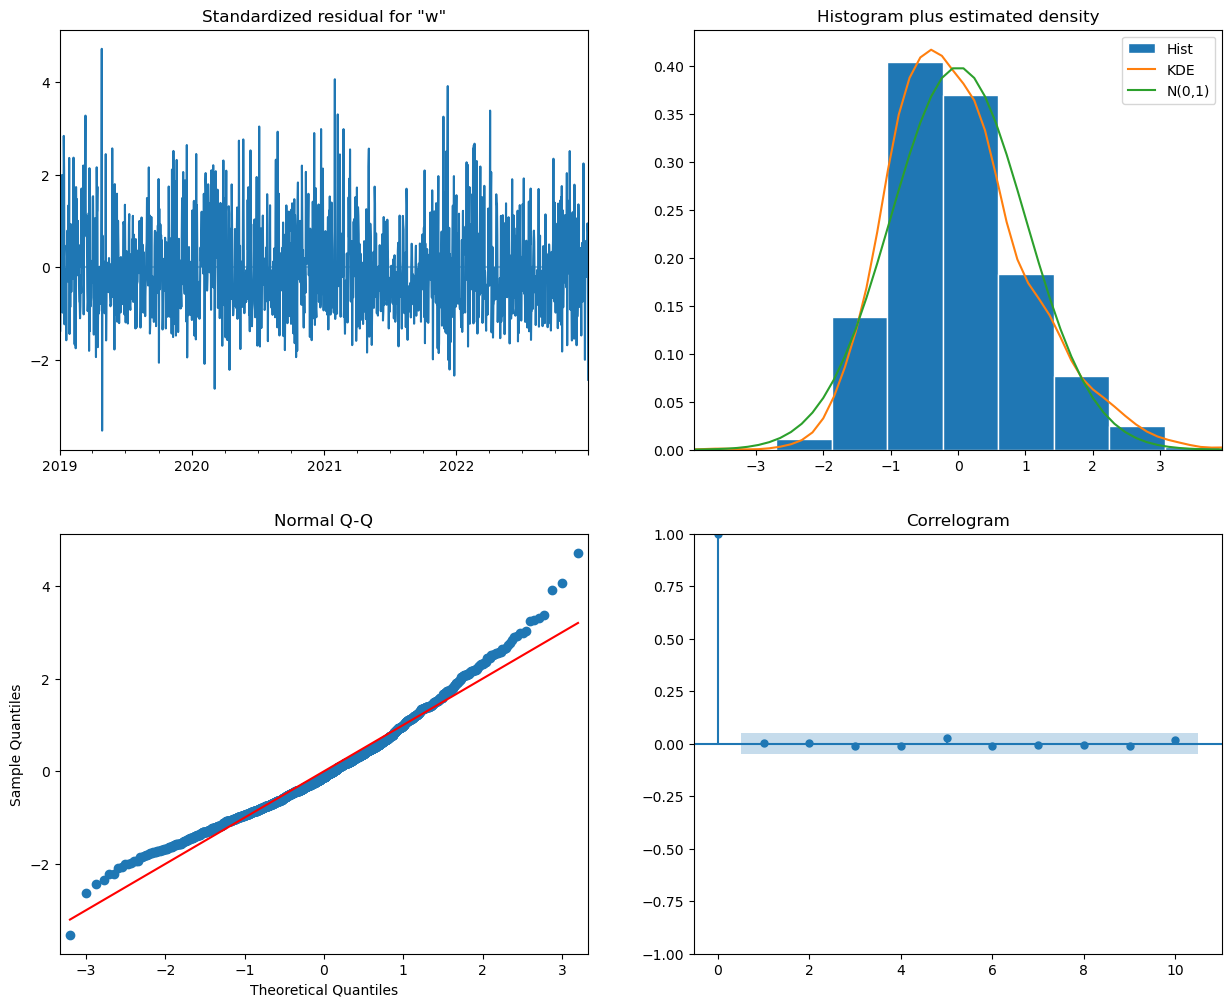

In [97]:
# Plot the diagnostics
fit102.plot_diagnostics(figsize=(15, 12))
plt.show()

In [98]:
acorr_ljungbox(fit102.resid, lags = 10)

,lb_stat,lb_pvalue
1,0.004102,0.948933
2,0.017079,0.991497
3,0.177485,0.981139
4,0.313805,0.988906
5,1.570584,0.904784
6,1.815391,0.935870
7,1.851646,0.967593
8,1.905178,0.983782
9,2.070185,0.990308
10,2.601669,0.989310


### Evaluation

#### ARIMA (1,0,2)

In [99]:
#producing the forecast using the fitted model
predictions_102 = fit102.forecast(len(test))

In [100]:
predictions_102

2023-01-01    6.654594
2023-01-02    8.374095
2023-01-03    8.543715
2023-01-04    8.673291
2023-01-05    8.772275
                ...   
2023-10-27    9.092568
2023-10-28    9.092568
2023-10-29    9.092568
2023-10-30    9.092568
2023-10-31    9.092568
Freq: D, Name: predicted_mean, Length: 304, dtype: float64

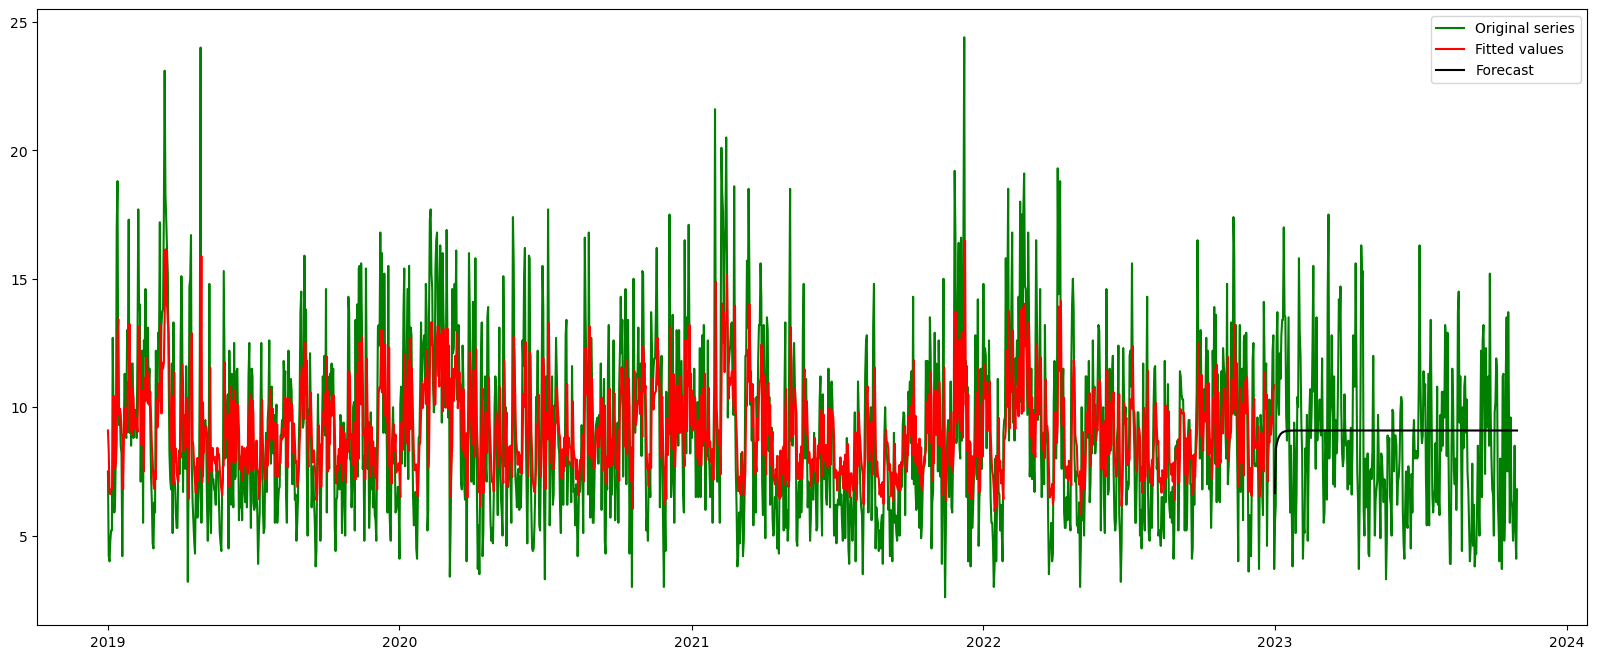

In [101]:
plt.figure(figsize = (20,8))
plt.plot(weather_model5["wdsp"], color = "green", label = "Original series")
plt.plot(fit102.fittedvalues, color = "red", label = "Fitted values")
plt.plot(predictions_102, color ="black", label ="Forecast")
plt.legend()

#### Evaluation of Model 5

In [102]:
arima_train_mean_absolute_error = mean_absolute_error(
    train["wdsp"],
    fit102.fittedvalues
)

arima_train_mean_squared_error = mean_squared_error(
    train["wdsp"],
    fit102.fittedvalues
)**0.5
arima_train_mean_absolute_perc_error = mean_absolute_percentage_error(
    train["wdsp"],
    fit102.fittedvalues
)

print("ARIMA(1,0,2) train- MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.3f}".format(arima_train_mean_absolute_error, arima_train_mean_squared_error, arima_train_mean_absolute_perc_error))


ARIMA(1,0,2) train- MAE: 2.317, RMSE: 2.946, MAPE: 0.289


In [103]:
arima_test_mean_absolute_error = mean_absolute_error(
    test["wdsp"],
    predictions_102
)

arima_test_mean_squared_error = mean_squared_error(
    test["wdsp"],
    predictions_102
)**0.5
arima_test_mean_absolute_perc_error = mean_absolute_percentage_error(
    test["wdsp"],
    predictions_102
)

print("ARIMA(1,0,2) test- MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.3f}".format(arima_test_mean_absolute_error, arima_test_mean_squared_error, arima_test_mean_absolute_perc_error))


ARIMA(1,0,2) test- MAE: 2.392, RMSE: 2.927, MAPE: 0.334
